In [116]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import keras
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Embedding, Dropout, AveragePooling1D, BatchNormalization
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TimothyKoei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\TimothyKoei\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [117]:
keras.utils.set_random_seed(4248)

In [118]:
train_df = pd.read_json('../train.jsonl', lines=True)
X_train = train_df['string']
y_train = train_df['label']

dev_df = pd.read_json('../dev.jsonl', lines=True)
X_dev = dev_df['string']
y_dev = dev_df['label']

test_df = pd.read_json('../test.jsonl', lines=True)
X_test = test_df['string']
y_test = test_df['label']

train_df

,source,citeEnd,sectionName,citeStart,string,label,label_confidence,citingPaperId,citedPaperId,isKeyCitation,id,unique_id,excerpt_index,label2,label2_confidence
0,explicit,175.0,Introduction,168.0,"However, how frataxin interacts with the Fe-S ...",background,1.0000,1872080baa7d30ec8fb87be9a65358cd3a7fb649,894be9b4ea46a5c422e81ef3c241072d4c73fdc0,True,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,11,NaN,NaN
1,explicit,36.0,Novel Quantitative Trait Loci for Seminal Root...,16.0,"In the study by Hickey et al. (2012), spikes w...",background,1.0000,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b,b6642e19efb8db5623b3cc4eef1c5822a6151107,True,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,2,NaN,NaN
2,explicit,228.0,Introduction,225.0,"The drug also reduces catecholamine secretion,...",background,1.0000,9cdf605beb1aa1078f235c4332b3024daa8b31dc,4e6a17fb8d7a3cada601d942e22eb5da6d01adbd,False,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,0,NaN,NaN
3,explicit,110.0,Discussion,46.0,By clustering with lowly aggressive close kin ...,background,1.0000,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,False,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,3,NaN,NaN
4,explicit,239.0,Discussion,234.0,Ophthalmic symptoms are rare manifestations of...,background,1.0000,88b86556857f4374842d2af2e359576806239175,a5bb0ff1a026944d2a47a155462959af2b8505a8,False,88b86556857f4374842d2af2e359576806239175>a5bb0...,88b86556857f4374842d2af2e359576806239175>a5bb0...,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8238,explicit,50.0,,28.0,"Importantly, the results of Pascalis et al. (2...",background,0.7350,6f68ccd37718366c40ae6aeedf0b935bf560b215,60ed4bdabf92b2fbd6162dbd8979888cccca55d7,True,6f68ccd37718366c40ae6aeedf0b935bf560b215>60ed4...,6f68ccd37718366c40ae6aeedf0b935bf560b215>60ed4...,15,NaN,NaN
8239,explicit,182.0,DISCUSSION,179.0,"As suggested by Nguena et al, there is a need ...",background,0.7508,f2a1c1704f9587c94ed95bc98179dc499e933f5e,574e659da7f6c62c07bfaaacd1f31d65bd75524c,True,f2a1c1704f9587c94ed95bc98179dc499e933f5e>574e6...,f2a1c1704f9587c94ed95bc98179dc499e933f5e>574e6...,1,NaN,NaN
8240,explicit,120.0,DISCUSSION,108.0,Skeletal muscle is also a primary site of dise...,background,1.0000,18c97ea2ff60c110cc2a523e0fdf729608cbb083,fc13b9c3dfcc121013edaa12fa8ce7842aaed21a,False,18c97ea2ff60c110cc2a523e0fdf729608cbb083>fc13b...,18c97ea2ff60c110cc2a523e0fdf729608cbb083>fc13b...,8,NaN,NaN
8241,explicit,221.0,,185.0,ACTIVATION OF TRANSCRIPTION FACTORS Roles for ...,method,NaN,4ec9b89857c0b27e8a4bd3745b7358f387773527,81affdba19e38e2b17cf7b9e93792cc2028cf21d,True,4ec9b89857c0b27e8a4bd3745b7358f387773527>81aff...,4ec9b89857c0b27e8a4bd3745b7358f387773527>81aff...,0,NaN,NaN


In [119]:
def cleaning(text):
    stop_words = stopwords.words('english')
    text = text.lower()
    text = ' '.join(x for x in text.split() if x not in stop_words)
    return text

In [120]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    words = []
    for x in text.split():
        x = lemmatizer.lemmatize(x)
        words.append(x)
    text = ' '.join(words)
    return text

In [121]:
def preprocessing(text):
    # Tokenization
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
    text = cleaning(text)
    text = lemmatize(text)
    text = ' '.join(tokenizer.tokenize(text))
    return text

In [122]:
def augment_data_multiclass(X, y):
    df = pd.concat([X, y], axis=1)
    majority_class_size = df['label'].value_counts().max()
    upsampled_dataframes = []
    for class_label in df['label'].unique():
        class_df = df[df['label'] == class_label]
        if len(class_df) < majority_class_size:
            class_df_upsampled = resample(class_df, replace=True, n_samples=majority_class_size, random_state=10)
            upsampled_dataframes.append(class_df_upsampled)
        else:
            upsampled_dataframes.append(class_df)
    upsampled_df = pd.concat(upsampled_dataframes)
    return upsampled_df['string'], upsampled_df['label']

In [123]:
X_train, y_train = augment_data_multiclass(X_train, y_train)

In [124]:
X_train_preprocessed = X_train.apply(lambda x: preprocessing(x))
X_dev_preprocessed = X_dev.apply(lambda x: preprocessing(x))
X_test_preprocessed = X_test.apply(lambda x: preprocessing(x))

# Feature Extraction

In [125]:
num_words = 5000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

In [126]:
X_train_tokenized = tokenizer.texts_to_sequences(X_train_preprocessed)
X_dev_tokenized = tokenizer.texts_to_sequences(X_dev_preprocessed)
X_test_tokenized = tokenizer.texts_to_sequences(X_test_preprocessed)

In [127]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

29836

In [128]:
initial_data = [X_train_tokenized, X_dev_tokenized, X_test_tokenized]
longest_length = -1
for dataset in initial_data:
    for arr in dataset:
        if len(arr) > longest_length:
            longest_length = len(arr)

longest_length

250

In [129]:
max_words = 250
X_train_padded = sequence.pad_sequences(X_train_tokenized, maxlen=max_words, padding='pre')
X_dev_padded = sequence.pad_sequences(X_dev_tokenized, maxlen=max_words, padding='pre')
X_test_padded = sequence.pad_sequences(X_test_tokenized, maxlen=max_words, padding='pre')

# Model

In [130]:
# http://nlp.stanford.edu/data/glove.6B.zip
embeddings_dictionary = dict()
f = open('../glove.6B/glove.6B.100d.txt', encoding="utf8")
for line in f.readlines():
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
f.close()

In [131]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.1529    , -0.24279   ,  0.89837003, ..., -0.59100002,
         1.00390005,  0.20664001],
       ...,
       [ 0.13266   ,  0.025495  , -0.35374001, ...,  0.037078  ,
        -0.54132003,  0.14563   ],
       [-0.60499001,  0.52837002,  0.29420999, ..., -0.37286001,
        -0.26356   ,  0.92654002],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [186]:
# Initializing CNN
model = Sequential()
model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=max_words, trainable=False))
model.add(BatchNormalization())

model.add(Conv1D(80, 3, padding='same', activation='relu', bias_regularizer=regularizers.l2(0.0005), kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPooling1D())

model.add(Conv1D(80, 3, padding='same', activation='linear', bias_regularizer=regularizers.l2(0.0005), kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())

model.add(Conv1D(120, 3, padding='same', activation='relu', bias_regularizer=regularizers.l2(0.0005), kernel_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPooling1D())

model.add(Flatten())

model.add(Dense(400, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(Dropout(0.4, seed=4248))

model.add(Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(Dropout(0.4, seed=4248))

model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)))
model.add(BatchNormalization())
model.add(Dropout(0.4, seed=4248))

model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 250, 100)          2983600   
                                                                 
 batch_normalization_40 (Ba  (None, 250, 100)          400       
 tchNormalization)                                               
                                                                 
 conv1d_20 (Conv1D)          (None, 250, 80)           24080     
                                                                 
 batch_normalization_41 (Ba  (None, 250, 80)           320       
 tchNormalization)                                               
                                                                 
 max_pooling1d_20 (MaxPooli  (None, 125, 80)           0         
 ng1D)                                                           
                                                     

In [187]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform string column
y_train = label_encoder.fit_transform(y_train)
y_dev = label_encoder.transform(y_dev)
y_test = label_encoder.transform(y_test)

print(y_train)

[0 0 0 ... 2 2 2]


In [188]:
history = model.fit(X_train_padded, 
          y_train, 
          validation_data=(X_dev_padded, y_dev), 
          epochs=20, 
          batch_size=128, 
          verbose=2)

Epoch 1/20
114/114 - 12s - loss: -4.8417e-01 - accuracy: 0.3526 - val_loss: 2.7677 - val_accuracy: 0.5677 - 12s/epoch - 108ms/step
Epoch 2/20
114/114 - 11s - loss: -9.7625e+00 - accuracy: 0.4104 - val_loss: 4.8262 - val_accuracy: 0.6168 - 11s/epoch - 92ms/step
Epoch 3/20
114/114 - 11s - loss: -2.5806e+01 - accuracy: 0.4200 - val_loss: 25.0431 - val_accuracy: 0.3199 - 11s/epoch - 94ms/step
Epoch 4/20
114/114 - 11s - loss: -4.6635e+01 - accuracy: 0.4427 - val_loss: -3.7561e+00 - val_accuracy: 0.5557 - 11s/epoch - 92ms/step
Epoch 5/20
114/114 - 12s - loss: -7.2799e+01 - accuracy: 0.4511 - val_loss: -3.7305e+00 - val_accuracy: 0.5404 - 12s/epoch - 104ms/step
Epoch 6/20
114/114 - 12s - loss: -1.0431e+02 - accuracy: 0.4744 - val_loss: -7.5532e+00 - val_accuracy: 0.5721 - 12s/epoch - 109ms/step
Epoch 7/20
114/114 - 13s - loss: -1.3774e+02 - accuracy: 0.4913 - val_loss: -1.4343e+01 - val_accuracy: 0.5786 - 13s/epoch - 110ms/step
Epoch 8/20
114/114 - 14s - loss: -1.7656e+02 - accuracy: 0.4938 -

In [189]:
scores = model.evaluate(X_test_padded, y_test)

print(f"Accuracy: {scores[1] * 100}%")

59/59 [==============================] - 1s 11ms/step - loss: -150.2589 - accuracy: 0.6636
Accuracy: 66.3621723651886%


In [190]:
# With reference to https://realpython.com/python-keras-text-classification/#your-first-keras-model
# Plotting histogram
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

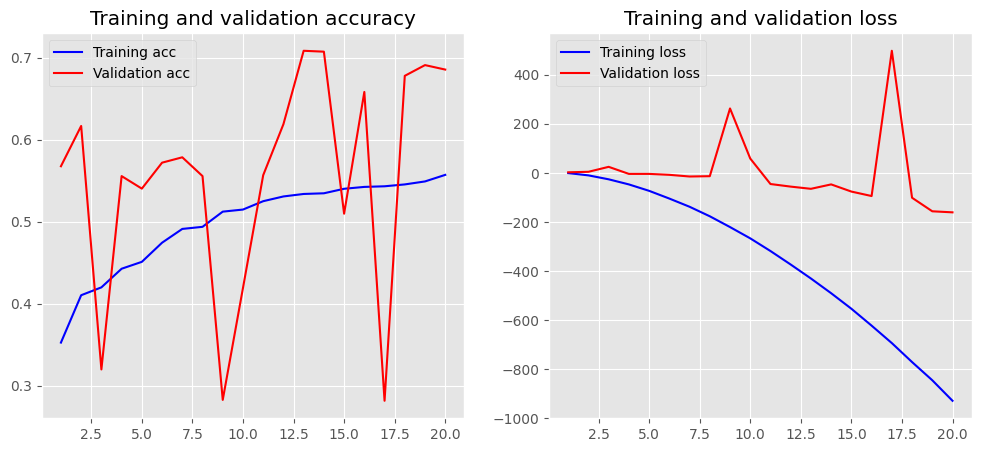

In [191]:
plot_history(history)
# history.history